In [4]:
# Builds basic transmission screens for nulling

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
# define the aperture

# Parameters for the grid and circles
N = 200  # size of the image, e.g., 200x200
radius = 10  # radius of each circle, in pixels
d = 70       # distance from center to the center of each circle (in pixels)
pixel_scale = 0.01  # meters per pixel ('pixel' here is the pixel in the image corresponding to the aperture, not nec. the detector)

# Create grid coordinates (x and y)
x = np.arange(N) - N // 2
y = np.arange(N) - N // 2
X, Y = np.meshgrid(x, y)

# Two circles, equidistant from center along the x-axis
circle1 = ((X - d/2)**2 + Y**2) < radius**2
circle2 = ((X + d/2)**2 + Y**2) < radius**2

# First slice: binary mask of the two circles (OR them together)
aperture = np.zeros((N, N), dtype=float)
aperture[(circle1 | circle2)] = 1

# Slices 2 and 3: x and y coordinates in meters
x_m = (X) * pixel_scale
y_m = (Y) * pixel_scale

# Make the 3D array
aperture_cube = np.zeros((3, N, N), dtype=float)
aperture_cube[0] = aperture
aperture_cube[1] = x_m
aperture_cube[2] = y_m


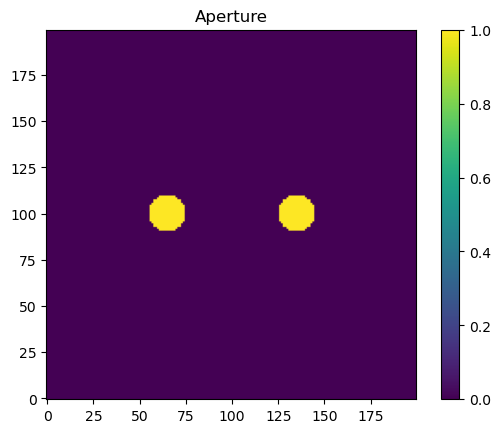

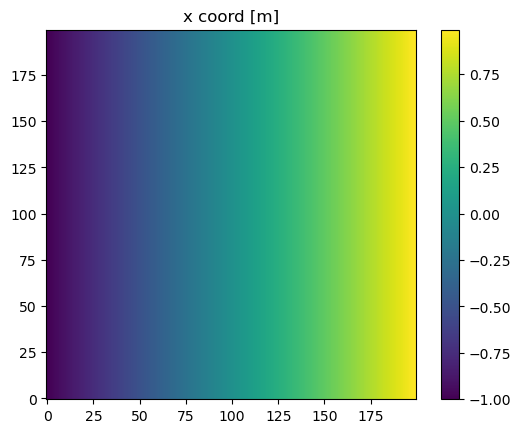

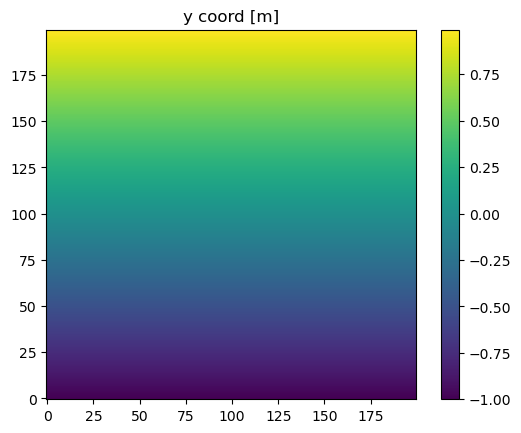

In [6]:
plt.imshow(aperture_cube[0], origin='lower')
plt.title('Aperture')
plt.colorbar()
plt.show()

plt.imshow(aperture_cube[1], origin='lower')
plt.title('x coord [m]')
plt.colorbar()
plt.show()

plt.imshow(aperture_cube[2], origin='lower')
plt.title('y coord [m]')
plt.colorbar()
plt.show()


In [7]:
# define the astrophysical scene

pixel_scale_onsky = 0.01  # arcseconds per pixel

# cube to hold the scene and on-sky coordinates
astro_cube = np.zeros((3, N, N), dtype=float)

# perfect on-sky scene
astro_scene = np.zeros((N, N), dtype=float)

# simple off-center star
row, col = 130, 80
astro_scene[row:row+4, col:col+4] = 1

# Create on-sky grid coordinates (x and y) in arcseconds
x = np.arange(N) - N // 2
y = np.arange(N) - N // 2
X, Y = np.meshgrid(x, y)

# Slices 2 and 3: x and y coordinates in meters
x_asec = (X) * pixel_scale_onsky
y_asec = (Y) * pixel_scale_onsky

# add the coordinates
astro_cube[0] = astro_scene
astro_cube[1] = y_asec
astro_cube[2] = x_asec

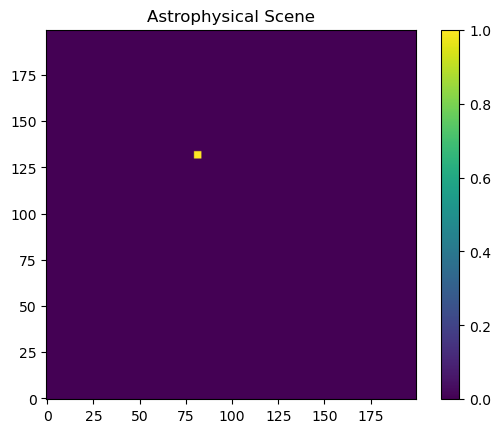

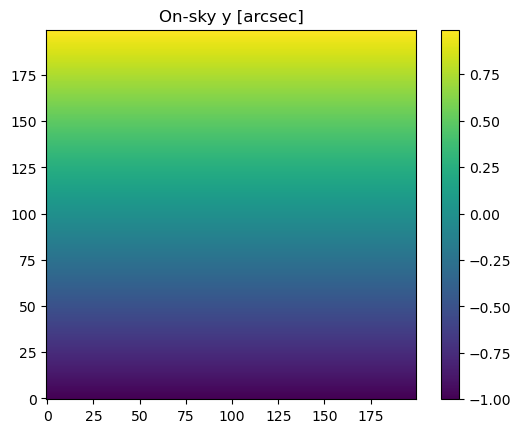

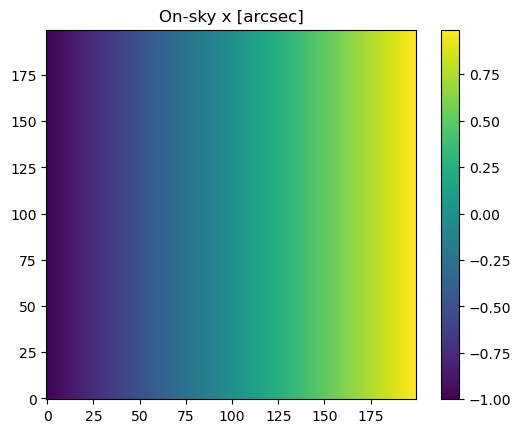

In [8]:
# plot astrophysical scene
plt.imshow(astro_cube[0], origin='lower')
plt.title('Astrophysical Scene')
plt.colorbar()
plt.show()

plt.imshow(astro_cube[1], origin='lower')
plt.title('On-sky y [arcsec]')
plt.colorbar()
plt.show()

plt.imshow(astro_cube[2], origin='lower')
plt.title('On-sky x [arcsec]')
plt.colorbar()
plt.show()

# apply the transmission screens to the astrophysical scene


In [9]:
# interferometer response as fcn of sky position (Dannert+ 2025 Eqn. B12, ignoring polarization for now)
# each element corresponds to one aperture

A_vec = np.array([1, 1]) # array of amplitudes
x_vec = np.array(([0, -1], [0, 1])) # array of vectors of aperture positions (y,x) [m]
phi_dc_vec_rad = np.array([0, np.pi/4]) # array of absolute DC (i.e., induced) phase offsets of each branch of the instrument [rad]
theta_vec_asec = np.array([0, 4]) # position of something on the sky (y_asec, x_asec) [arcsec]
wavel_m = 1e-6 # wavelength in meters

In [ ]:

#del_phi_dc_jk = phi_dc_vec[0] - phi_dc_vec[1] # differential phase between two branches
#del_x_jk = x_vec[0] - x_vec[1] # baseline from one aperture to another
#print(np.dot(del_x_jk, theta_vec))

-3.141592653589793


In [97]:
def old_R_theta_vec(A_vec, x_vec, phi_dc_vec_rad, theta_vec_2d_asec, wavel_m):
    # theta_vec_rad: cube with slice 0 = y_asec, slice 1 = x_asec

    del_phi_dc_jk_rad = phi_dc_vec_rad[1] - phi_dc_vec_rad[0] # differential phase between two branches [rad]

    print('del_phi_dc_jk_rad')
    print(del_phi_dc_jk_rad)

    print('theta_vec_2d_asec')
    print(theta_vec_2d_asec)
    theta_vec_rad_array = np.divide(theta_vec_2d_asec, 206265) # convert to rad

    del_x_jk = x_vec[1] - x_vec[0] # baseline from one aperture to another [m]

    # initialize the instrument response array 
    R_theta_vec = np.zeros(np.shape(theta_vec_2d_asec[0]))

    # for each sky position, compute the instrument response
    print(np.shape(R_theta_vec))
    print('ha')
    #print(R_theta_vec.shape)
    for i in range(0,np.shape(R_theta_vec)[1]): # y
        for j in range(0,np.shape(R_theta_vec)[0]): # x
            print('--------------------------------')
            print(i)
            print(j)

            theta_vec_rad_this = np.array([theta_vec_rad_array[0,j,i], theta_vec_rad_array[1,j,i]])

            R_theta_vec[j,i] = A_vec[0] * A_vec[1] * ( np.cos(del_phi_dc_jk_rad) * np.cos( (2*np.pi / wavel_m) * np.dot( del_x_jk, theta_vec_rad_this ) ) - np.sin(del_phi_dc_jk_rad) * np.sin( (2*np.pi / wavel_m) * np.dot( del_x_jk, theta_vec_rad_this ) ) ) # np.dot() units are m

    return R_theta_vec

In [ ]:
def R_theta_vec(A_vec, x_vec, phi_dc_vec_rad, theta_vec_2d_asec, wavel_m, incl_comp_transmission=False):
    # instrument respose over the sky (Dannert 2025 Eqn. B12)
    # N.b. this is the interferometric response (it can have negative values), not a transmission map 

    '''
    INPUTS:
    A_vec: array of amplitudes
    x_vec: array of vectors of aperture positions (y,x) [m]
    phi_dc_vec_rad: array of absolute DC (i.e., induced) phase offsets of each branch of the instrument [rad]
    theta_vec_2d_asec: cube with slice 0 = y_asec, slice 1 = x_asec
    wavel_m: wavelength in meters
    incl_comp_transmission: boolean, if True, include the transmissions of the component baselines in slice 1 to -3

    OUTPUT:
    R_theta_vec: instrument response over the sky; slices are
      [0] = total instrument response
      [1:-3] = instrument responses of the component baselines
      [-2] = y coord in sky [arcsec]
      [-1] = x coord in sky [arcsec]
    '''

    # theta_vec_rad: cube with slice 0 = y_asec, slice 1 = x_asec
    # Vectorized version that works for arbitrary number of apertures
    
    # Convert sky positions from arcsec to radians
    theta_vec_rad_array = np.divide(theta_vec_2d_asec, 206265)  # shape: (2, Ny, Nx)
    
    # Get number of apertures
    N_apertures = len(A_vec)
    
    # Initialize the instrument response array
    R_theta_vec = np.zeros(np.shape(theta_vec_2d_asec[0]))  # shape: (Ny, Nx)
    
    # Calculate total number of baselines (unique pairs of apertures)
    # For N apertures, number of unique baselines = N*(N-1)/2
    N_baselines = N_apertures * (N_apertures - 1) // 2
    print(f'Total number of baselines: {N_baselines}')

    #if incl_comp_transmission:
    #    cube_canvas = np.zeros((N_baselines+3, N, N))

    cube_canvas = np.zeros((3, N, N))

    # Sum over all pairs of apertures (j, k) where j < k
    for j in range(N_apertures):
        for k in range(j + 1, N_apertures):

            # Differential phase between apertures j and k [rad]
            del_phi_dc_jk_rad = phi_dc_vec_rad[k] - phi_dc_vec_rad[j]
            
            # Baseline from aperture j to aperture k [m]
            del_x_jk = x_vec[k] - x_vec[j]  # shape: (2,)
            
            # Compute phase term for all sky positions at once using broadcasting
            # theta_vec_rad_array has shape (2, Ny, Nx), del_x_jk has shape (2,)
            # We want to compute dot(del_x_jk, theta_vec_rad_array) for all positions
            # This gives shape (Ny, Nx)
            phase_term = (2 * np.pi / wavel_m) * (
                del_x_jk[0] * theta_vec_rad_array[0] +  # y component
                del_x_jk[1] * theta_vec_rad_array[1]    # x component
            )
            
            # Use cosine addition formula: cos(a + b) = cos(a)cos(b) - sin(a)sin(b)
            # This is more efficient than computing cos and sin separately
            # Eqn. B12 in Dannert 2025
            response_jk = A_vec[j] * A_vec[k] * np.cos(del_phi_dc_jk_rad + phase_term)
            
            # Add contribution from this pair to the total response
            '''
            plt.clf()
            plt.imshow(response_jk)
            plt.colorbar()
            plt.show()

            # if incl_comp_transmission, add this as a separate slice
            if incl_comp_transmission:
            '''

            # Add contribution from this pair to the total response
            R_theta_vec += response_jk

    # cube_canvas[0,:,:] = R_theta_vec
    cube_canvas[0,:,:] = R_theta_vec
    cube_canvas[1:,:,:] = theta_vec_rad_array[0,:,:] # y-coords [asec]
    cube_canvas[2:,:,:] = theta_vec_rad_array[1,:,:] # x-coords [asec]
    
    return cube_canvas

In [14]:
# example response screen
A_vec = np.array([1, 1, 1])
x_vec = np.array(([0, -1], [0, 1], [1, 1]))
phi_dc_vec_rad = np.array([0, np.pi/4, 0])
response_cube = R_theta_vec(A_vec=A_vec, x_vec=x_vec, phi_dc_vec_rad=phi_dc_vec_rad, theta_vec_2d_asec=astro_cube[1:,:,:], wavel_m=wavel_m)

Total number of baselines: 3


In [15]:
np.shape(response_cube)

(3, 200, 200)

/var/folders/wb/zn41c4yx58z1ktmcwgv62zyr0000gn/T/ipykernel_24966/4219824121.py:6: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(np.abs(test_new_fft)), origin='lower')


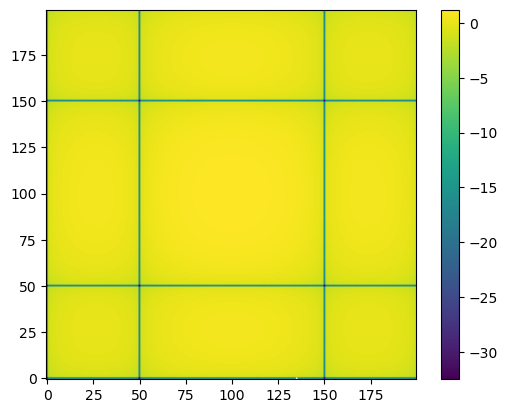

In [16]:
# FFT of a scene
test_new_fft = np.fft.fftshift(np.fft.fft2(astro_cube[0,:,:]))



plt.imshow(np.log10(np.abs(test_new_fft)), origin='lower')
plt.colorbar()
plt.show()



In [26]:
def symm_asymm_scene(scene):
    '''
    INPUTS:
    scene: 2D array of the astrophysical scene

    OUTPUTS:
    scene_symm: 2D array of the symmetrical part of the astrophysical scene
    scene_asymm: 2D array of the asymmetrical part of the astrophysical scene
    '''

    # generate the (a)symmetrical parts of the astrophysical source
    scene_flipped = np.flip(np.flip(scene, axis=0), axis=1)

    scene_symm = (scene + scene_flipped) / 2
    scene_asymm = (scene - scene_flipped) / 2

    return scene_symm, scene_asymm

In [28]:
scene_symm_test, scene_asymm_test = symm_asymm_scene(astro_cube[0,:,:])

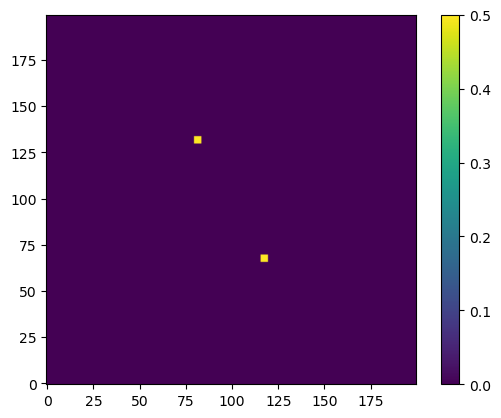

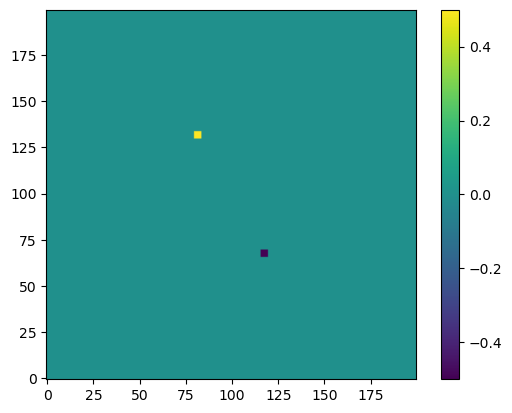

In [29]:
plt.imshow(scene_symm_test, origin='lower')
plt.colorbar()
plt.show()

plt.imshow(scene_asymm_test, origin='lower')
plt.colorbar()
plt.show()

In [ ]:
def B_twiddle_sky_symm_asymm(B_sky_symm, B_sky_asymm, x_vec_j, x_vec_k, theta_vec_2d_asec, wavel_m):
    '''
    Definition of B_twiddle, for (a)symmetrical parts of the astrophysical source 
    (Eqn. B18, Dannert 2025)

    INPUTS:
    B_sky_symm: cube containing slices 2D array of the symmetrical part of the astrophysical scene
    B_sky_asymm: ditto for the asymmetrical part
    x_vec: array of vectors of aperture positions (y,x) [m]; ex. np.array(([0, -1], [0, 1], [1, 1]))
    theta_vec_2d_asec: cube with slice 0 = y_asec, slice 1 = x_asec; ex. theta_vec_2d_asec[1:,:,:]
    wavel_m: wavelength in meters

    RETURNS:
    B_twiddle_sky_symm_baseline_this: scalar of the symmetrical part of the B_twiddle, for this baseline
    B_twiddle_sky_asymm_baseline_this: ditto for the asymmetrical part
    '''

    del_x_jk = x_vec_k - x_vec_j

    # Convert sky positions from arcsec to radians
    theta_vec_rad_array = np.divide(theta_vec_2d_asec, 206265)  # shape: (2, Ny, Nx)

    phase_term = (2 * np.pi / wavel_m) * (
        del_x_jk[0] * theta_vec_rad_array[0] +  # y component
        del_x_jk[1] * theta_vec_rad_array[1]    # x component
    )

    # Extract the scene data from the cubes (slice [0] contains the 2D scene array)

    # integrate by summing over the pixel solid angles
    d_omega = np.abs(theta_vec_rad_array[0,0,1] - theta_vec_rad_array[0,0,0]) * np.abs(theta_vec_rad_array[1,1,0] - theta_vec_rad_array[1,0,0]) # one pixel

    # Compute the integral: sum over all sky positions
    B_twiddle_sky_symm_baseline_this = np.sum( B_sky_symm * np.cos(phase_term) * d_omega )
    B_twiddle_sky_asymm_baseline_this = -1j * np.sum( B_sky_asymm * np.sin(phase_term) * d_omega )

    print(np.shape(B_twiddle_sky_symm_baseline_this))
    print(np.shape(B_twiddle_sky_asymm_baseline_this))

    plt.imshow(B_twiddle_sky_symm_baseline_this, origin='lower')
    plt.colorbar()
    plt.show()

    plt.imshow(B_twiddle_sky_asymm_baseline_this, origin='lower')
    plt.colorbar()
    plt.show()

    return B_twiddle_sky_symm_baseline_this, B_twiddle_sky_asymm_baseline_this

()
()


TypeError: Invalid shape () for image data

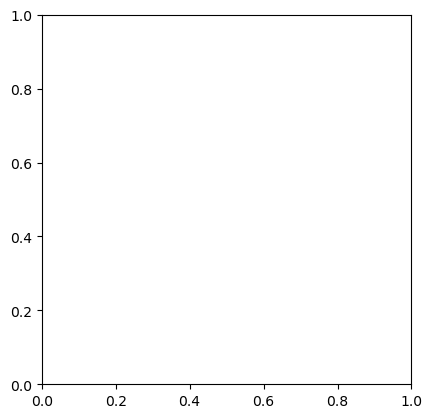

In [44]:
test = B_twiddle_sky_symm_asymm(B_sky_symm=scene_symm_test, B_sky_asymm=scene_asymm_test, x_vec_j=x_vec[0], x_vec_k=x_vec[1], theta_vec_2d_asec=astro_cube[1:,:,:], wavel_m=wavel_m)

In [34]:
print(test)

(np.float64(0.0), -0j)


In [ ]:
def B_twiddle_sky_asymm(B_sky_asymm, x_vec_j, x_vec_k, theta_vec_2d_asec, wavel_m):
    '''
    Definition of B_twiddle, for asymmetrical part of the astrophysical source 
    (Eqn. B18, Dannert 2025, part 2)

    INPUTS:
    B_sky_symm: cube containing slices 
        [0] = 2D array of the symmetrical part of the astrophysical scene
        [1] = y [arcsec]
        [2] = x [arcsec]
    x_vec: array of vectors of aperture positions (y,x) [m]; ex. np.array(([0, -1], [0, 1], [1, 1]))
    theta_vec_2d_asec: cube with slice 0 = y_asec, slice 1 = x_asec; ex. theta_vec_2d_asec[1:,:,:]
    wavel_m: wavelength in meters
    '''

    del_x_jk = x_vec_k - x_vec_j

    # Convert sky positions from arcsec to radians
    theta_vec_rad_array = np.divide(theta_vec_2d_asec, 206265)  # shape: (2, Ny, Nx)

    phase_term = (2 * np.pi / wavel_m) * (
        del_x_jk[0] * theta_vec_rad_array[0] +  # y component
        del_x_jk[1] * theta_vec_rad_array[1]    # x component
    )

    # Extract the scene data from the cube (slice [0] contains the 2D scene array)
    B_sky_symm_scene = B_sky_symm[0]  # shape: (Ny, Nx)

    # integrate by summing over the pixel solid angles
    d_omega = np.abs(theta_vec_rad_array[0,0,1] - theta_vec_rad_array[0,0,0]) * np.abs(theta_vec_rad_array[1,1,0] - theta_vec_rad_array[1,0,0]) # one pixel
    
    # Compute the integral: sum over all sky positions
    B_twiddle_sky_symm_baseline_this = np.sum( B_sky_symm_scene * np.cos(phase_term) * d_omega)

    return B_twiddle_sky_symm_baseline_this

(3, 200, 200)

In [ ]:
def photon_rate_1(del_wavel, A_vec, x_vec, phi_dc_vec_rad, theta_vec_2d_asec, wavel_m, incl_comp_transmission=False):
    '''
    Finds rate of incoming photons (Eqn. B19, Dannert 2025), using method of FTing the (a)symmetrical parts of the astrophysical source separately
    
    INPUTS:
    del_wavel: bandpass [m]
    A_vec: array of amplitudes
    x_vec: array of vectors of aperture positions (y,x) [m]
    phi_dc_vec_rad: array of absolute DC (i.e., induced) phase offsets of each branch of the instrument [rad]
    theta_vec_2d_asec: cube with slice 0 = y_asec, slice 1 = x_asec
    wavel_m: wavelength in meters
    incl_comp_transmission: boolean, if True, include the transmissions of the component baselines in slice 1 to -3

    OUTPUT:
    R_theta_vec: instrument response over the sky; slices are
      [0] = total instrument response
      [1:-3] = instrument responses of the component baselines
      [-2] = y coord in sky [arcsec]
      [-1] = x coord in sky [arcsec]
    '''

    # theta_vec_rad: cube with slice 0 = y_asec, slice 1 = x_asec
    # Vectorized version that works for arbitrary number of apertures
    
    # Convert sky positions from arcsec to radians
    theta_vec_rad_array = np.divide(theta_vec_2d_asec, 206265)  # shape: (2, Ny, Nx)
    
    # Get number of apertures
    N_apertures = len(A_vec)
    
    # Initialize the instrument response array
    R_theta_vec = np.zeros(np.shape(theta_vec_2d_asec[0]))  # shape: (Ny, Nx)
    
    # Calculate total number of baselines (unique pairs of apertures)
    # For N apertures, number of unique baselines = N*(N-1)/2
    N_baselines = N_apertures * (N_apertures - 1) // 2
    print(f'Total number of baselines: {N_baselines}')

    cube_canvas = np.zeros((3, N, N))

    # Sum over all pairs of apertures (j, k) where j < k
    for j in range(N_apertures):
        for k in range(j + 1, N_apertures):

            # Differential phase between apertures j and k [rad]
            del_phi_dc_jk_rad = phi_dc_vec_rad[k] - phi_dc_vec_rad[j]
            
            # Baseline from aperture j to aperture k [m]
            del_x_jk = x_vec[k] - x_vec[j]  # shape: (2,)

            # argument x_jk/lambda
            arg_x_jk_lambda = (del_x_jk / wavel_m)

            response_jk = A_vec[j] * A_vec[k] * np.cos(del_phi_dc_jk_rad + phase_term)
            
            # Add contribution from this pair to the total response
            '''
            plt.clf()
            plt.imshow(response_jk)
            plt.colorbar()
            plt.show()

            # if incl_comp_transmission, add this as a separate slice
            if incl_comp_transmission:
            '''

            # Add contribution from this pair to the total response
            R_theta_vec += response_jk

    # cube_canvas[0,:,:] = R_theta_vec
    cube_canvas[0,:,:] = R_theta_vec
    cube_canvas[1:,:,:] = theta_vec_rad_array[0,:,:] # y-coords [asec]
    cube_canvas[2:,:,:] = theta_vec_rad_array[1,:,:] # x-coords [asec]
    
    return cube_canvas

In [41]:
def fft_of_astro(astro_cube):
    '''
    Take FFT of an astrophysical scene

    INPUTS:
    astro_cube: 3D array with slices [0] = scene, [1] = y [arcsec], [2] = x [arcsec]

    OUTPUTS:
    fft_cube: 3D array with slices [0] = complex FFT of response, [1] = fy (cycles per arcsec), [2] = fx (cycles per arcsec)
    '''

    # Build FFT cube with associated spatial-frequency coordinates
    # test_new[0,:,:] is on a regular sky grid with pixel scale 'pixel_scale_onsky' [arcsec/pixel]
    # Here we attach frequency-space coordinates (cycles per arcsec) for y and x.

    Ny, Nx = test_new[0].shape

    pixel_scale_onsky = astro_cube[1,0,1] - astro_cube[1,0,0]

    # Spatial-frequency coordinates (cycles per arcsec)
    # np.fft.fftfreq uses spacing 'd' in arcsec/pixel, so output is cycles/arcsec
    freq_y = np.fft.fftshift(np.fft.fftfreq(Ny, d=pixel_scale_onsky))  # row (y) frequencies
    freq_x = np.fft.fftshift(np.fft.fftfreq(Nx, d=pixel_scale_onsky))  # column (x) frequencies

    # Make 2D grids so each Fourier pixel has its (fy, fx)
    fx_grid, fy_grid = np.meshgrid(freq_x, freq_y)  # shapes (Ny, Nx)

    # Build a cube analogous to astro_cube / test_new:
    #   [0] = complex FFT of response
    #   [1] = fy (cycles per arcsec)
    #   [2] = fx (cycles per arcsec)

    fft_cube = np.zeros((3, Ny, Nx), dtype=complex)
    fft_cube[0] = test_new_fft
    fft_cube[1] = fy_grid
    fft_cube[2] = fx_grid

    print(fy_grid)

    # Add a top row of subplots to show the input astrophysical scene and coordinates.

    # Consolidate all subplots into a single figure with six axes
    fig, axes = plt.subplots(3, 3, figsize=(14, 8))

    # Top row: input scene and coordinates
    im00 = axes[0, 0].imshow(astro_cube[0], origin="lower")
    axes[0, 0].set_title("Input Scene")
    plt.colorbar(im00, ax=axes[0, 0])

    im01 = axes[0, 1].imshow(astro_cube[1], origin="lower")
    axes[0, 1].set_title("Y [arcsec]")
    plt.colorbar(im01, ax=axes[0, 1])

    im02 = axes[0, 2].imshow(astro_cube[2], origin="lower")
    axes[0, 2].set_title("X [arcsec]")
    plt.colorbar(im02, ax=axes[0, 2])

    # Middle row: Fourier plots
    im10 = axes[1, 0].imshow(np.log10(np.abs(fft_cube[0]) + 1e-12), origin="lower")
    axes[1, 0].set_title("log10 |FFT(response)|")
    plt.colorbar(im10, ax=axes[1, 0])

    im11 = axes[1, 1].imshow(fft_cube[0].real, origin="lower")
    axes[1, 1].set_title("Re{FFT(response)}")
    plt.colorbar(im11, ax=axes[1, 1])

    im12 = axes[1, 2].imshow(fft_cube[0].imag, origin="lower")
    axes[1, 2].set_title("Im{FFT(response)}")
    plt.colorbar(im12, ax=axes[1, 2])

    # Bottom row: Fourier-space coordinates (two subplots only)
    im20 = axes[2, 0].imshow(fft_cube[1,:,:], origin="lower")   
    axes[2, 0].set_title("fy [cycles/arcsec]")
    plt.colorbar(im20, ax=axes[2, 0])

    im21 = axes[2, 1].imshow(fft_cube[2,:,:], origin="lower")
    axes[2, 1].set_title("fx [cycles/arcsec]")
    plt.colorbar(im21, ax=axes[2, 1])

    plt.tight_layout()
    plt.show()

    return fft_cube


In [40]:
test[1,:,:]

array([[-inf+0.j, -inf+0.j, -inf+0.j, ..., -inf+0.j, -inf+0.j, -inf+0.j],
       [-inf+0.j, -inf+0.j, -inf+0.j, ..., -inf+0.j, -inf+0.j, -inf+0.j],
       [-inf+0.j, -inf+0.j, -inf+0.j, ..., -inf+0.j, -inf+0.j, -inf+0.j],
       ...,
       [ inf+0.j,  inf+0.j,  inf+0.j, ...,  inf+0.j,  inf+0.j,  inf+0.j],
       [ inf+0.j,  inf+0.j,  inf+0.j, ...,  inf+0.j,  inf+0.j,  inf+0.j],
       [ inf+0.j,  inf+0.j,  inf+0.j, ...,  inf+0.j,  inf+0.j,  inf+0.j]],
      shape=(200, 200))

[[-inf -inf -inf ... -inf -inf -inf]
 [-inf -inf -inf ... -inf -inf -inf]
 [-inf -inf -inf ... -inf -inf -inf]
 ...
 [ inf  inf  inf ...  inf  inf  inf]
 [ inf  inf  inf ...  inf  inf  inf]
 [ inf  inf  inf ...  inf  inf  inf]]


/Users/eckhartspalding/miniconda3/envs/life/lib/python3.10/site-packages/numpy/fft/_helper.py:170: RuntimeWarning: divide by zero encountered in scalar divide
  val = 1.0 / (n * d)
/Users/eckhartspalding/miniconda3/envs/life/lib/python3.10/site-packages/numpy/fft/_helper.py:177: RuntimeWarning: invalid value encountered in multiply
  return results * val


TypeError: Image data of dtype complex128 cannot be converted to float

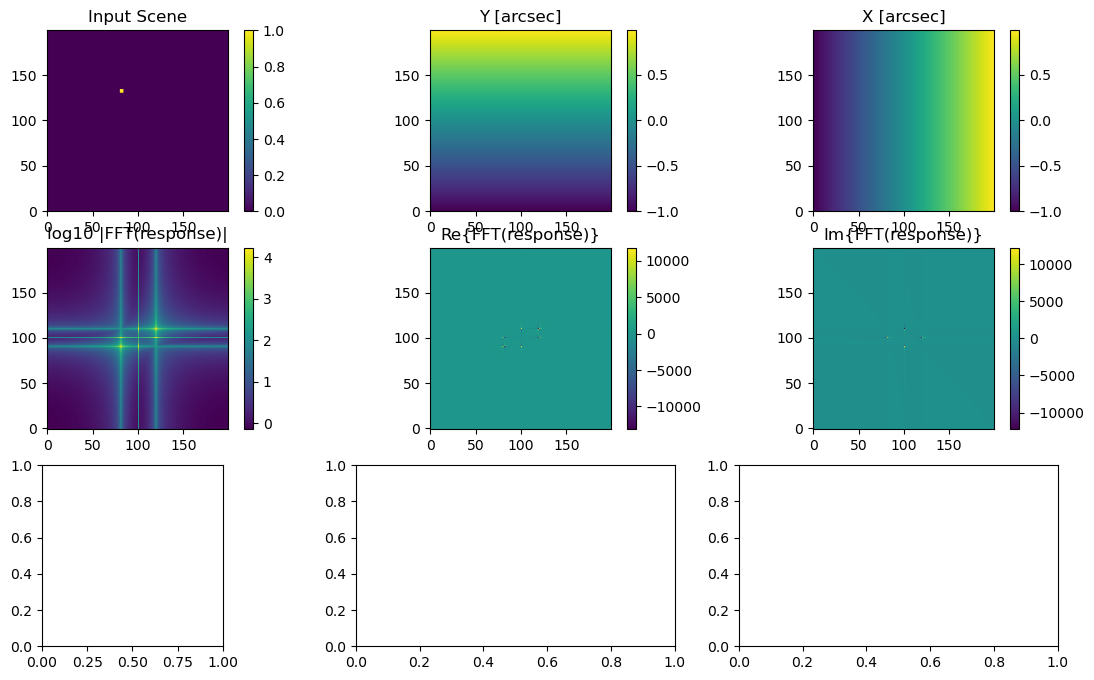

In [42]:
scene_astrophysical = astro_cube
test = fft_of_astro(astro_cube)

In [11]:
print(np.max(test_new[0,:,:]))
print(np.min(test_new[0,:,:]))

2.999784538515729
-1.4999169567854085


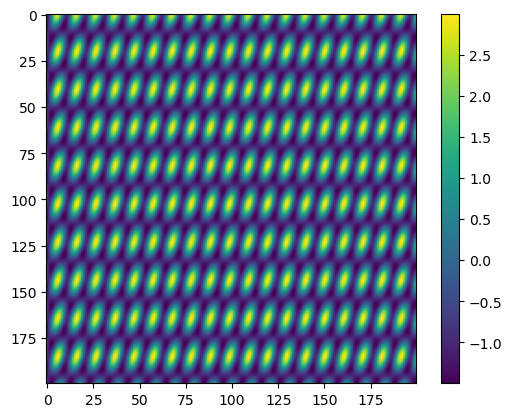

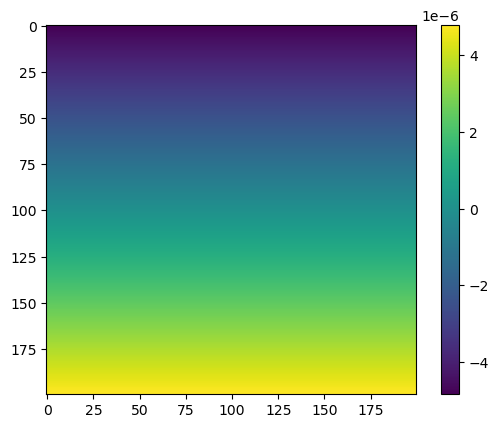

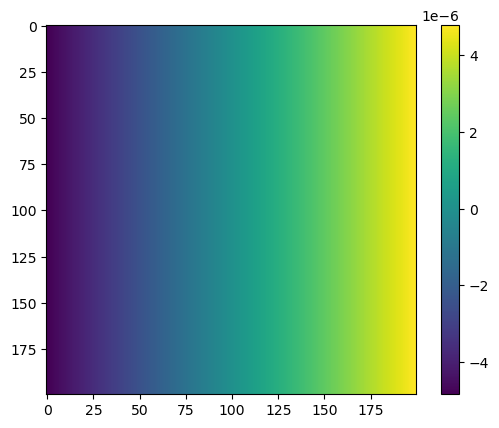

In [9]:

plt.imshow(test_new[0,:,:])
plt.colorbar()
plt.show()


plt.imshow(test_new[1,:,:])
plt.colorbar()
plt.show()


plt.imshow(test_new[2,:,:])
plt.colorbar()
plt.show()

In [10]:
# total photon rate (Dannert 2025 Eqn. B19, ignoring polarization for now)

def n_tot(del_lambda, Aj, Ak, del_phi_jk, B_twiddle_sky_symm, B_twiddle_sky_asymm):

    n = del_lambda * Aj * Ak * ( np.cos(del_phi_jk) * B_twiddle_sky_symm - 1j * np.sin(del_phi_jk) * B_twiddle_sky_asymm )

    return n